In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.stats
import statsmodels.api as sm

# <font face="gotham" color="purple">What Is Qualitative Response Model?</font>

So far we have only discussed the model that takes $Y$ as a quantitative variable by default, however there are situations we want $Y$ to be qualitative variable, for example, $Y = 1$ represents a family owns house, $Y=0$ means not owning a flat, independent variables can be quantitative variables such as their income, ages, education and etc.

Specifically, if the response variables only takes two values, such as $1$ or $0$, we call them **binary variable**, the regression model with binary variable as dependent variable is called **binary response regression model**, similarly there is also **trichotomous response regression model** or more generally **polychotomous response regression model**, but names do not matter, they are all **qualitative response model** as in the question of this section.

For easy demonstration, we will mostly deal with _binary response model_, there are four approaches to develop this type of model: **linear probability model**, **logit model**, **probit model** and **tobit model**. 

We will go through all of them in this chapter.

# <font face="gotham" color="purple">The Linear Probability Model (LPM)</font>

Consider a simple regression model
$$
Y_{i}=\beta_{1}+\beta_{2} X_{i}+u_{i}
$$
where $X$ represents family income, $Y=1$ represents if the family owns a flat and $0$ the opposite. There are only two outcomes, either own a flat or not, so $Y_i$ follows **Bernoulli Distribution**.

It would be fast to recognize the $u_i$ can't be normally distributed, since
$$
u_{i}=Y_{i}-\beta_{1}-\beta_{2} X_{i}
$$
If we denote the probability $Y_i=1$ as $P_i$ and $Y_i=0$ as $1-P_i$, then
$$
\begin{array}{lcc} 
& u_{i} & \text { Probability } \\
\text { When } Y_{i}=1 & 1-\beta_{1}-\beta_{2} X_{i} & P_{i} \\
\text { When } Y_{i}=0 & -\beta_{1}-\beta_{2} X_{i} & \left(1-P_{i}\right)
\end{array}
$$
it shows that $u_i$ also follows Bernoulli distribution.

Recall the fact from statistics course, that the variance of Bernoulli distribution is $P_i(1-P_i)$, what's more
$$
E\left(Y_{i} \mid X_{i}\right)=\beta_{1}+\beta_{2} X_{i}=0\left(1-P_{i}\right)+1\left(P_{i}\right)=P_{i}
$$
The $P_i$ is a function of $X_i$, hence $u_i$ is heteroskedastic. 

## <font face="gotham" color="purple">Home Owners' Example</font>

Here is an excerpt data from a real estate survey in Manchester, UK. The family income is measured in thousand pounds.

In [84]:
df = pd.read_excel('Basic_Econometrics_practice_data.xlsx', sheet_name = 'HouseOwn_Quali_Resp'); df.head()

,Annual_Family_Income,Own_House
0,56,1
1,78,1
2,67,0
3,34,1
4,23,0


Perform a quick OLS estimation (ignoring the heteroskedasticity for now) and plot the regression line.

In [85]:
X = df['Annual_Family_Income']
Y = df['Own_House']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit() 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              Own_House   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     50.32
Date:                Thu, 02 Sep 2021   Prob (F-statistic):           2.47e-08
Time:                        14:34:24   Log-Likelihood:                -10.752
No. Observations:                  38   AIC:                             25.50
Df Residuals:                      36   BIC:                             28.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1981 

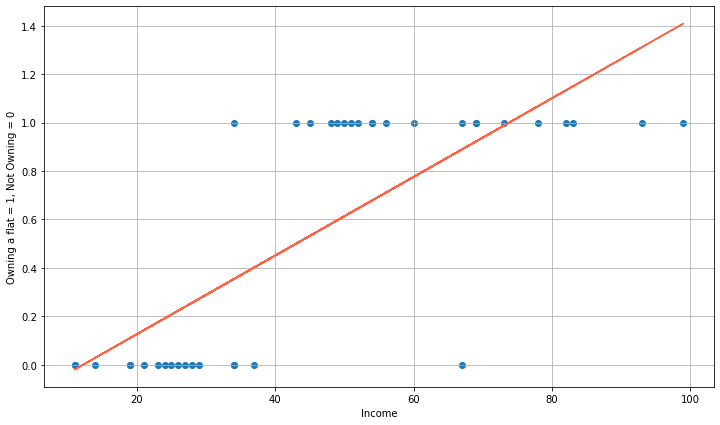

In [86]:
fig, ax = plt.subplots(figsize = (12, 7))
ax.scatter(df['Annual_Family_Income'], df['Own_House'])
ax.plot(df['Annual_Family_Income'], model.fittedvalues, color = 'tomato')
ax.grid()
ax.set_xlabel('Income')
ax.set_ylabel('Owning a flat = 1, Not Owning = 0')
plt.show()

Let's interpret the results, the constant term is $-0.1981$, but probability can never be negative, hence we ignore constant term, or simply treat it as $0$. The slope term $0.0162$ indicates that in average with every $1000$ pounds increment in family income, the probability of owning a house will increase $1.6\%$.

However, you could doubt its reliability that assuming income and probability is linear relation, actually it's more rational to assume there is some threshold to afford a house, if the house cost $500000$ pounds, earning $20000$ shouldn't be any obvious improvement than earning $10000$. Similarly, family with income of $200000$ wouldn't be much different than family with income of $190000$. We will talk about how to model this assumption in next section. So far we will stick with LPM.

What if a family has $39000$ pounds of annual income? Our model predicts the probability they own a house is $-0.1981 + 39\times0.0162=.43$. But how about family income of $11000$ pounds? The models says $-0.1981 + 11\times0.0162=-0.0199$, it predicts a negative probability and apparent it has no sense. Similarly, if a family has $99000$ pounds income, the model predicts a probability $-0.1981 + 99\times0.0162=1.4057$ which is more than $1$.

If the vertical axis represents probabilities, i.e. $0 \leq E\left(Y_{i} \mid X_{i}\right) \leq 1 $, it would be a natural defects of LPM to predict out of this range.

However, we still haven't address the heteroskedasticity issue of LPM, which means the estimated results above are actually all _invalid_! For fast remedy, you can invoke the White's robust standard error.

In [87]:
model.HC0_se

const                   0.086859
Annual_Family_Income    0.001809
dtype: float64

To handle the issue more seriously, we use WLS to obtain more efficient estimates. Because variance of disturbance term is 
$$
\operatorname{var}\left(u_{i}\right)=P_{i}\left(1-P_{i}\right)=\sqrt{E\left(Y_{i} \mid X_{i}\right)\left[1-E\left(Y_{i} \mid X_{i}\right)\right]}
$$
So we estimate the disturbance term by using fitted values, note that these are different than residuals!
$$
w_i=\hat{Y}_{i}\left(1-\hat{Y}_{i}\right)
$$

Add fitted value into the data frame.

In [71]:
df['fitted_value'] = model.fittedvalues
df.head()

,Annual_Family_Income,Own_House,fitted_value
0,56,1,0.710644
1,78,1,1.067667
2,67,0,0.889155
3,34,1,0.353621
4,23,0,0.175110


Exclude all values out of probabilistic range, then calculate the weight.

In [74]:
df = df[df['fitted_value']>0]
df = df[df['fitted_value']<1]
df['weight'] = np.sqrt(df['fitted_value']*(1-df['fitted_value']))

In [76]:
df.head()

,Annual_Family_Income,Own_House,fitted_value,weight
0,56,1,0.710644,0.453463
2,67,0,0.889155,0.313940
3,34,1,0.353621,0.478093
4,23,0,0.175110,0.380061
5,19,0,0.110197,0.313135


Divide weight onto every terms in the model
$$
\frac{Y_{i}}{\sqrt{w_{i}}}=\frac{\beta_{1}}{\sqrt{w_{i}}}+\beta_{2} \frac{X_{i}}{\sqrt{w_{i}}}+\frac{u_{i}}{\sqrt{w_{i}}}
$$

In [77]:
df['Annual_Family_Income_WLS'] = df['Annual_Family_Income']/df['weight']
df['Own_House_WLS'] = df['Own_House']/df['weight']

Here's the more reliable result.

In [78]:
X = df['Annual_Family_Income_WLS']
Y = df['Own_House_WLS']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit() 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:          Own_House_WLS   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     94.47
Date:                Thu, 02 Sep 2021   Prob (F-statistic):           1.25e-10
Time:                        14:17:57   Log-Likelihood:                -40.040
No. Observations:                  31   AIC:                             84.08
Df Residuals:                      29   BIC:                             86.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

The slope estimates of WLS is similar but higher significance due to smaller standard error and $R^2$ also much higher than previous model.

Though we have fixed heteroskedasticity to some extent, the model is not attractive both in breaking probabilistic range and its linear shape. Next sections we will talk about alternatives to LPM that fulfill both probabilistic range and nonlinear shape. 